In [1]:
import numpy as np
import sys
import torch
import time
from ctypes import *

if "/home/yskim/projects/sparse-bfp" not in sys.path:
    sys.path.append("/home/yskim/projects/sparse-bfp")

from util.bfp.bfp_config import BfpConfig
from util.custom_transpose import custom_transpose_2d
from util.bfp.bfp_gemm import BfpGemm

In [2]:
def load_inout(
    path_root: str, 
    phase: str, 
    layer_index: int) -> tuple[torch.Tensor, torch.Tensor]:
    path = f"{path_root}/{phase}-{layer_index}-fp"

    lhs = np.load(f"{path}-lhs.npy", allow_pickle=False)
    rhs = np.load(f"{path}-rhs.npy", allow_pickle=False)

    return (torch.tensor(lhs), torch.tensor(rhs))

def get_gemm_results(
    lhs: torch.Tensor, 
    rhs: torch.Tensor, 
    is_flex_bfp: bool) -> tuple[torch.Tensor, torch.Tensor, float, float]:

    M = lhs.shape[0]
    K = lhs.shape[1]
    N = rhs.shape[1]
    print(f"dims: [{M}, {K}] x [{K}, {N}]")

    if not is_flex_bfp:
        print(f"BFP m bits: {BfpConfig.bfp_M_Bit}")
        # print(f"sort size: {BfpConfig.chunk_size_to_sort}")
    else:
        print("Flex BFP")

    rhs_t = torch.empty((N, K), dtype=torch.float).to('cuda')
    custom_transpose_2d(dst=rhs_t, src=rhs)

    bfp_gemm = BfpGemm(
        lhs.shape,
        rhs_t.shape,
        use_stochastic_rounding=True,
        use_flex_bfp=(True if is_flex_bfp else False)
    )

    bfp_outputs = bfp_gemm.run(lhs, rhs_t)
    fp_outputs = torch.matmul(lhs, rhs)

    lhs_E = bfp_gemm.lhs_wrapper.bfp_E.flatten().type(dtype=torch.float)
    rhs_E = bfp_gemm.rhs_wrapper.bfp_E.flatten().type(dtype=torch.float)
    print(f"")
    print(f"lhs mean: {torch.mean(lhs_E):02.1f}, max: {torch.max(lhs_E):02.1f}, min: {torch.min(lhs_E):02.1f}")
    print(f"rhs mean: {torch.mean(rhs_E):02.1f}, max: {torch.max(rhs_E):02.1f}, min: {torch.min(rhs_E):02.1f}")

    lhs_bit = np.mean(bfp_gemm.lhs_wrapper.bfp_bit_level.cpu().numpy().flatten())
    rhs_bit = np.mean(bfp_gemm.rhs_wrapper.bfp_bit_level.cpu().numpy().flatten())

    return (fp_outputs, bfp_outputs, lhs_bit, rhs_bit)

In [3]:
BfpConfig.bfp_M_Bit = 2
log_path = "/home/yskim/projects/sparse-bfp/resnet50-inout-log/epoch0-lr0.001"
is_flex_bfp = False
phase = "bwd-a"
start = 1
end = 53

def get_results(
    log_path: str, 
    phase: str, 
    layer_start: int, 
    layer_end: int, 
    is_flex_bfp: bool):
    bfp_bit = BfpConfig.bfp_M_Bit
    for i in range(layer_start, layer_end):
        print(i)
        lhs, rhs = load_inout(log_path, phase, i)
        fp_outputs, bfp_outputs, lhs_bit, rhs_bit = get_gemm_results(lhs.to("cuda"), rhs.to("cuda"), is_flex_bfp=is_flex_bfp)

        if is_flex_bfp:
            bfp_label = "flex-bfp"
        else:
            bfp_label = f"bfp-{bfp_bit}-bit"

        # print(f"{log_path}/{phase}-{i}-{bfp_label}-outputs.npy")
        # print(f"{log_path}/{phase}-{i}-fp-outputs.npy")

        np.save(
            f"{log_path}/{phase}-{i}-{bfp_label}-outputs.npy", 
            bfp_outputs.cpu().numpy(),
            allow_pickle=False)

        np.save(
            f"{log_path}/{phase}-{i}-fp-outputs.npy", 
            fp_outputs.cpu().numpy(),
            allow_pickle=False)

        if is_flex_bfp:
            avg_bit_array = np.array([lhs_bit, rhs_bit])
            # print(avg_bit_array)
            # print(f"{log_path}/{phase}-{i}-{bfp_label}-inout-avg-bit.npy")
            np.save(
                f"{log_path}/{phase}-{i}-{bfp_label}-inout-avg-bit.npy",
                avg_bit_array,
                allow_pickle=False)

        # bfp_diff = torch.abs(fp_outputs.flatten() - bfp_outputs.flatten())

        # fp_outputs, bfp_outputs, lhs_bit, rhs_bit = get_gemm_results(lhs.to("cuda"), rhs.to("cuda"), is_flex_bfp=True)
        # flex_bfp_diff = torch.abs(fp_outputs.flatten() - bfp_outputs.flatten())

        # print(f"[diffs]")
        # print(f"[flex-bfp avg. bit] lhs: {lhs_bit:.2f}, rhs: {rhs_bit:.2f}")
        # print(f"[mean] bfp-{bfp_bit}: {torch.mean(bfp_diff):.10f}, flex-bfp: {torch.mean(flex_bfp_diff):.10f}")
        # print(f"[max]: bfp-{bfp_bit}: {torch.max(bfp_diff):.10f}, flex-bfp: {torch.max(flex_bfp_diff):.10f}")
        # print(f"[min]: bfp-{bfp_bit}: {torch.min(bfp_diff):.10f}, flex-bfp: {torch.min(flex_bfp_diff):.10f}")
        # print()
    

In [4]:
get_results(log_path, phase, start, end, is_flex_bfp)

1
dims: [8192, 64] x [64, 64]
BFP m bits: 2

lhs mean: -13.8, max: -11.0, min: -18.0
rhs mean: -2.0, max: -1.0, min: -3.0
2
dims: [8192, 64] x [64, 576]
BFP m bits: 2

lhs mean: -13.9, max: -10.0, min: -20.0
rhs mean: -3.6, max: -3.0, min: -5.0
3
dims: [8192, 256] x [256, 64]
BFP m bits: 2

lhs mean: -14.0, max: -11.0, min: -19.0
rhs mean: -3.0, max: -2.0, min: -4.0
4
dims: [8192, 256] x [256, 64]
BFP m bits: 2

lhs mean: -14.2, max: -10.0, min: -20.0
rhs mean: -3.0, max: -2.0, min: -4.0
5
dims: [8192, 64] x [64, 256]
BFP m bits: 2

lhs mean: -15.7, max: -13.0, min: -23.0
rhs mean: -2.0, max: -1.0, min: -3.0
6
dims: [8192, 64] x [64, 576]
BFP m bits: 2

lhs mean: -14.4, max: -11.0, min: -21.0
rhs mean: -3.6, max: -2.0, min: -5.0
7
dims: [8192, 256] x [256, 64]
BFP m bits: 2

lhs mean: -14.5, max: -11.0, min: -20.0
rhs mean: -3.0, max: -2.0, min: -4.0
8
dims: [8192, 64] x [64, 256]
BFP m bits: 2

lhs mean: -16.3, max: -13.0, min: -22.0
rhs mean: -2.0, max: -1.0, min: -3.0
9
dims: [8192,

In [5]:
# BfpConfig.bfp_M_Bit = 8
# log_path = "/home/yskim/projects/sparse-bfp/resnet50-inout-log/epoch20-lr0.001"
# phase = "bwd-a"
start = 1
end = 2

def geo_mean(array: np.array):
    return array.prod() ** (1.0 / len(array))

diffs_8bit = []
diffs_6bit = []
diffs_4bit = []
diffs_2bit = []
diffs_flex = []
avg_bits = []
# lhs_bits = []
# rhs_bits = []

for i in range(start, end):
    fp = np.load(
        f"{log_path}/{phase}-{i}-fp-outputs.npy", 
        allow_pickle=False)

    bfp_8bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-8-bit-outputs.npy", 
        allow_pickle=False)

    bfp_6bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-6-bit-outputs.npy", 
        allow_pickle=False)

    bfp_4bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-4-bit-outputs.npy", 
        allow_pickle=False)

    bfp_2bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-2-bit-outputs.npy", 
        allow_pickle=False)

    bfp_flex = np.load(
        f"{log_path}/{phase}-{i}-flex-bfp-outputs.npy", 
        allow_pickle=False)

    flex_bits = np.load(
        f"{log_path}/{phase}-{i}-flex-bfp-inout-avg-bit.npy", 
        allow_pickle=False).flatten()
    fp = fp + 1e-15
    diff_8bit = np.mean(np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.)
    diff_6bit = np.mean(np.abs(1. - np.abs(bfp_6bit / fp).flatten()) * 100.)
    diff_4bit = np.mean(np.abs(1. - np.abs(bfp_4bit / fp).flatten()) * 100.)
    diff_2bit = np.mean(np.abs(1. - np.abs(bfp_2bit / fp).flatten()) * 100.)
    diff_flex = np.mean(np.abs(1. - np.abs(bfp_flex / fp).flatten()) * 100.)

    print(f"8bit: {diff_8bit:.2f}%, ", end="")
    print(f"6bit: {diff_6bit:.2f}%, ", end="")
    print(f"4bit: {diff_4bit:.2f}%, ", end="")
    print(f"2bit: {diff_2bit:.2f}%, ", end="")
    print(f"flex: {diff_flex:.2f}% (avg bit: {np.mean(flex_bits):.2f})")

    # fp_flatten = fp.flatten()
    # diff_8bit = np.mean(np.abs(fp - bfp_8bit).flatten()) + 1e-15
    # diff_6bit = np.mean(np.abs(fp - bfp_6bit).flatten()) + 1e-15
    # diff_4bit = np.mean(np.abs(fp - bfp_4bit).flatten()) + 1e-15
    # diff_2bit = np.mean(np.abs(fp - bfp_2bit).flatten()) + 1e-15
    # diff_flex = np.mean(np.abs(fp - bfp_flex).flatten()) + 1e-15

    diffs_8bit.append(diff_8bit)
    diffs_6bit.append(diff_6bit)
    diffs_4bit.append(diff_4bit)
    diffs_2bit.append(diff_2bit)
    diffs_flex.append(diff_flex)
    avg_bits.append(np.mean(flex_bits))

    # diffs_8bit.append(diff_8bit)
    # diffs_6bit.append(diff_6bit)
    # diffs_4bit.append(diff_4bit)
    # diffs_2bit.append(diff_2bit)
    # diffs_flex.append(diff_flex)
    # lhs_bits.append(flex_bits[0])
    # rhs_bits.append(flex_bits[1])

    # print(f"[{phase}-{i:02}] ", end="")
    # print(f"8bit: {diff_8bit:.15f}, ", end="")
    # print(f"6bit: {diff_6bit:.15f}, ", end="")
    # print(f"4bit: {diff_4bit:.15f}, ", end="")
    # print(f"2bit: {diff_2bit:.15f}, ", end="")
    # print(f"flex: {diff_flex:.15f} (bit: {flex_bits[0]:.1f}, {flex_bits[1]:.1f})")


    # print(f"{fp[0,0]:.15f}")
    # print(f"{bfp_8bit[0,0]:.15f}")
    # print(f"{bfp_6bit[0,0]:.15f}")
    # print(f"{bfp_4bit[0,0]:.15f}")
    # print(f"{bfp_2bit[0,0]:.15f}")
    # print(f"{bfp_flex[0,0]:.15f}")
    # print(f"{abs(1. - abs(bfp_8bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_6bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_4bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_2bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_flex[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(np.max(np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.))

    bfp_8bit_flat = bfp_8bit.flatten()
    fp_flat = fp.flatten()

    # curr_max = 0
    # for i in range(fp_flat.size):
    #     curr_error = np.abs(1. - np.abs(bfp_8bit_flat[i] / fp_flat[i])) * 100.

    #     if curr_max < curr_error:
    #         curr_bfp = bfp_8bit_flat[i]
    #         curr_fp = fp_flat[i]
    #         curr_max = curr_error
    # print(curr_max)
    # print(f"{curr_bfp:.15f}")
    # print(f"{curr_fp:.15f}")

    dist_8bit = np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.
    # dist_6bit = np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.
    # dist_4bit = np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.
    dist_2bit = np.abs(1. - np.abs(bfp_2bit / fp).flatten()) * 100.

    print(np.min(dist_2bit))
    print(np.max(dist_2bit))
    dist_2bit_sorted = np.sort(dist_2bit)
    size = int(np.floor(dist_2bit_sorted.size * 0.1))
    print(dist_2bit_sorted.size)
    print(size)
    # print(dist_8bit_sorted[-1])
    print(np.mean(dist_2bit))
    print(np.mean(dist_2bit_sorted[0:dist_2bit_sorted.size-size]))

8bit: 8.06%, 6bit: 56.56%, 4bit: 241.51%, 2bit: 976.37%, flex: 976.37% (avg bit: 0.00)
0.00054836273
112158184.0
524288
52428
976.37
46.38463


In [12]:
# BfpConfig.bfp_M_Bit = 8
# log_path = "/home/yskim/projects/sparse-bfp/resnet50-inout-log/epoch20-lr0.001"
# phase = "bwd-a"
start = 1
end = 2

def geo_mean(array: np.array):
    return array.prod() ** (1.0 / len(array))

diffs_8bit = []
diffs_6bit = []
diffs_4bit = []
diffs_2bit = []
diffs_flex = []
avg_bits = []
# lhs_bits = []
# rhs_bits = []

for i in range(start, end):
    fp = np.load(
        f"{log_path}/{phase}-{i}-fp-outputs.npy", 
        allow_pickle=False)

    bfp_8bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-8-bit-outputs.npy", 
        allow_pickle=False)

    bfp_6bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-6-bit-outputs.npy", 
        allow_pickle=False)

    bfp_4bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-4-bit-outputs.npy", 
        allow_pickle=False)

    bfp_2bit = np.load(
        f"{log_path}/{phase}-{i}-bfp-2-bit-outputs.npy", 
        allow_pickle=False)

    bfp_flex = np.load(
        f"{log_path}/{phase}-{i}-flex-bfp-outputs.npy", 
        allow_pickle=False)

    flex_bits = np.load(
        f"{log_path}/{phase}-{i}-flex-bfp-inout-avg-bit.npy", 
        allow_pickle=False).flatten()
    fp = fp + 1e-15
    diff_8bit = np.mean(np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.)
    diff_6bit = np.mean(np.abs(1. - np.abs(bfp_6bit / fp).flatten()) * 100.)
    diff_4bit = np.mean(np.abs(1. - np.abs(bfp_4bit / fp).flatten()) * 100.)
    diff_2bit = np.mean(np.abs(1. - np.abs(bfp_2bit / fp).flatten()) * 100.)
    diff_flex = np.mean(np.abs(1. - np.abs(bfp_flex / fp).flatten()) * 100.)

    print(f"8bit: {diff_8bit:.2f}%, ", end="")
    print(f"6bit: {diff_6bit:.2f}%, ", end="")
    print(f"4bit: {diff_4bit:.2f}%, ", end="")
    print(f"2bit: {diff_2bit:.2f}%, ", end="")
    print(f"flex: {diff_flex:.2f}% (avg bit: {np.mean(flex_bits):.2f})")

    # fp_flatten = fp.flatten()
    # diff_8bit = np.mean(np.abs(fp - bfp_8bit).flatten()) + 1e-15
    # diff_6bit = np.mean(np.abs(fp - bfp_6bit).flatten()) + 1e-15
    # diff_4bit = np.mean(np.abs(fp - bfp_4bit).flatten()) + 1e-15
    # diff_2bit = np.mean(np.abs(fp - bfp_2bit).flatten()) + 1e-15
    # diff_flex = np.mean(np.abs(fp - bfp_flex).flatten()) + 1e-15

    diffs_8bit.append(diff_8bit)
    diffs_6bit.append(diff_6bit)
    diffs_4bit.append(diff_4bit)
    diffs_2bit.append(diff_2bit)
    diffs_flex.append(diff_flex)
    avg_bits.append(np.mean(flex_bits))

    # diffs_8bit.append(diff_8bit)
    # diffs_6bit.append(diff_6bit)
    # diffs_4bit.append(diff_4bit)
    # diffs_2bit.append(diff_2bit)
    # diffs_flex.append(diff_flex)
    # lhs_bits.append(flex_bits[0])
    # rhs_bits.append(flex_bits[1])

    # print(f"[{phase}-{i:02}] ", end="")
    # print(f"8bit: {diff_8bit:.15f}, ", end="")
    # print(f"6bit: {diff_6bit:.15f}, ", end="")
    # print(f"4bit: {diff_4bit:.15f}, ", end="")
    # print(f"2bit: {diff_2bit:.15f}, ", end="")
    # print(f"flex: {diff_flex:.15f} (bit: {flex_bits[0]:.1f}, {flex_bits[1]:.1f})")


    # print(f"{fp[0,0]:.15f}")
    # print(f"{bfp_8bit[0,0]:.15f}")
    # print(f"{bfp_6bit[0,0]:.15f}")
    # print(f"{bfp_4bit[0,0]:.15f}")
    # print(f"{bfp_2bit[0,0]:.15f}")
    # print(f"{bfp_flex[0,0]:.15f}")
    # print(f"{abs(1. - abs(bfp_8bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_6bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_4bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_2bit[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(f"{abs(1. - abs(bfp_flex[0,0] / (fp[0,0] + 1e-15))) * 100.}%")
    # print(np.max(np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.))

    bfp_8bit_flat = bfp_8bit.flatten()
    fp_flat = fp.flatten()

    # curr_max = 0
    # for i in range(fp_flat.size):
    #     curr_error = np.abs(1. - np.abs(bfp_8bit_flat[i] / fp_flat[i])) * 100.

    #     if curr_max < curr_error:
    #         curr_bfp = bfp_8bit_flat[i]
    #         curr_fp = fp_flat[i]
    #         curr_max = curr_error
    # print(curr_max)
    # print(f"{curr_bfp:.15f}")
    # print(f"{curr_fp:.15f}")

    dist_8bit = np.abs(1. - np.abs(bfp_2bit / fp)) * 100.
    # dist_6bit = np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.
    # dist_4bit = np.abs(1. - np.abs(bfp_8bit / fp).flatten()) * 100.
    dist_2bit = np.abs(1. - np.abs(bfp_2bit / fp)) * 100.

    print(dist_8bit.shape)

    row_cnt = {}
    col_cnt = {}

    outliers = []
    non = []
    outlier_cnt = 0
    non_cnt = 0
    for r in range(dist_8bit.shape[0]):
        for c in range(dist_8bit.shape[1]):
            if dist_8bit[r, c] > 30.:
                outlier_cnt += 1
                # print(f"bfp: {bfp_8bit[r,c]:.15f}, fp: {fp[r,c]:.15f}, {dist_8bit[r,c]:.2f}")

                outliers.append(dist_8bit[r, c])
                if r not in row_cnt.keys():
                    row_cnt[r] = 1
                else:
                    row_cnt[r] += 1

                if c not in col_cnt.keys():
                    col_cnt[c] = 1
                else:
                    col_cnt[c] += 1
            else:
                non_cnt += 1
                non.append(dist_8bit[r, c])

    print(f"mean: {np.mean(outliers):.2f}% ({outlier_cnt})")
    print(f"non mean: {np.mean(non):.2f}%")
    print(f"entire mean: {np.mean(non + outliers)} ({non_cnt})")
    print(f"size: {dist_8bit.size}")
    print(f"outlier percentage: {(outlier_cnt / (outlier_cnt+non_cnt)) * 100.:.2f}%")
    print(f"min: {np.min(outliers)}")
    print(f"max: {np.max(outliers)}")

    # for key in row_cnt.keys():
    #     print(f"{key}: {row_cnt[key]}")
    # print()

    # for key in col_cnt.keys():
    #     print(f"{key}: {col_cnt[key]}")



    # print(np.min(dist_2bit))
    # print(np.max(dist_2bit))
    # dist_2bit_sorted = np.sort(dist_2bit)
    # size = int(np.floor(dist_2bit_sorted.size * 0.1))
    # print(dist_2bit_sorted.size)
    # print(size)
    # # print(dist_8bit_sorted[-1])
    # print(np.mean(dist_2bit))
    # print(np.mean(dist_2bit_sorted[0:dist_2bit_sorted.size-size]))

8bit: 8.06%, 6bit: 56.56%, 4bit: 241.51%, 2bit: 976.37%, flex: 976.37% (avg bit: 0.00)
(8192, 64)
mean: 1063.69% (115297)
non mean: 9.74%
entire mean: 241.5133819580078 (408991)
size: 524288
outlier percentage: 21.99%
min: 30.000083923339844
max: 48842784.0


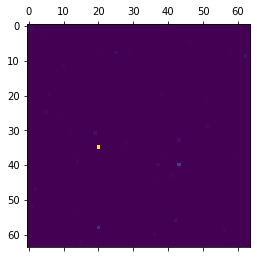

In [7]:
import matplotlib.pyplot as plt
import numpy as np
start = 64 * 100
arr = dist_8bit[start:start+64,:]
plt.matshow(arr)

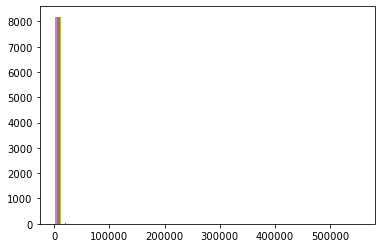

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# plt.ylim(0, 100.)
result = plt.hist(dist_8bit, range=(0, 553887.2), bins=40)

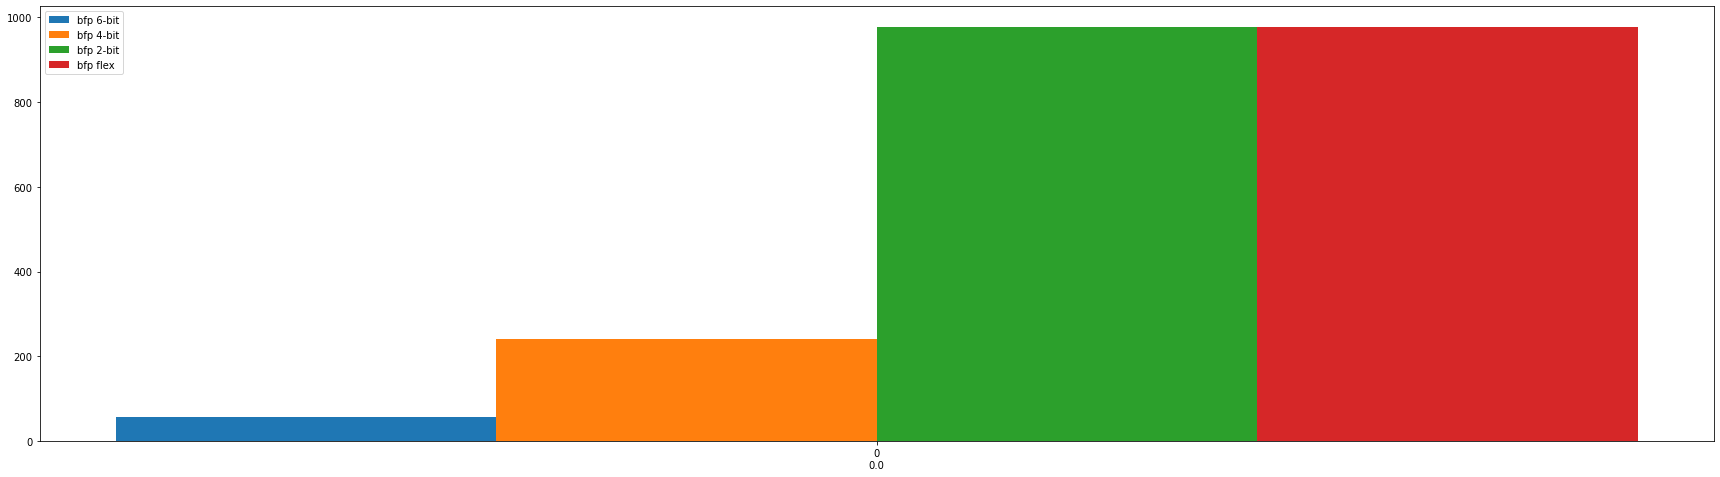

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# labels = ['G1', 'G2', 'G3', 'G4', 'G5']

x = np.arange(len(diffs_8bit) * 2)  # the label locations
x_ = np.arange(len(diffs_8bit)) * 2  # the label locations
width = 0.3  # the width of the bars

plt.figure(figsize=(30,8))
# fig, ax = plt.subplots()
plt.bar(x_ - 3 * (width/2), diffs_6bit, width, label='bfp 6-bit')
plt.bar(x_ - 1 * (width/2), diffs_4bit, width, label='bfp 4-bit')
plt.bar(x_ + 1 * (width/2), diffs_2bit, width, label='bfp 2-bit')
plt.bar(x_ + 3 * (width/2), diffs_flex, width, label='bfp flex')
# print(len(diffs_flex))

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# labels = np.arange(len(diffs_8bit))
labels = [f"{i}\n{avg_bits[i]:.1f}" for i in range(len(diffs_8bit))]
# plt.title("ResNet50 on CIFAR100 (epoch 20, lr: 0.001)")
plt.xticks(x_, labels)
plt.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)


plt.show()